# Model-Free Summary

Overview: 

* This version is updated on 1/12/2023

* Major updates: 
    - revise model1 "refreshing": remove retrieval, use encoding-only
    - reward probability: random walk is enabled
    - randomness is fixed: reward probability is fixed across simulation
    - parameter `M`: a scale parameter that scales the amount of reward 
        For example, M = 0, mental clock is lowest, agent will purely rely on model-free approach
        When M = 1, mental clock takes the same value as reward
        When M = 2, mental clock = reward * 2
        When M -> +infinite, metal clock is highest, agent will purely rely on model-based approach

Main Takeaways:

* n = 500 is good enough, n = 100 may not work as expected 
    
* actr parameters: 
    - small noise parameter may cause problem: `ans:0.1, egs:0.1` --> high P(stay)
    
    - good parameter set: 
        > `actr_params={'seed':'nil', 'ans':0.2, 'egs':0.5, 'alpha':0.2, 'v':'nil', 'lf':1, 'bll':0.5, 'mas':2}`

    - important: in model1, cannot refresh infinite times, because reward delivery is dependent on time spend ( set refresh-done in goal buffer)


In [1]:
import sys
import os

SCRIPT_PATH = os.path.join(os.path.abspath(os.path.dirname('../__file__')), 'script')
sys.path.insert(0, SCRIPT_PATH)

#from markov_device import *
from markov_simulate_test import *
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import pandas.api.types as pdtypes

%matplotlib inline

ACT-R connection has been started.


In [3]:
model_name="markov-model1"
r = 5
task_params={'REWARD': {'B1': r, 'B2': r, 'C1':r, 'C2': r}}
actr_params={'ans':0.5, 'egs':0.5, 'alpha':0.5, 'v':'nil', 'lf':1, 'bll':0.5, 'mas':2}

e=2
n=50

In [4]:
load = False

if load:
    df1_state1stay=pd.read_csv('../data/markov-model1-state1stay.csv', index_col=0, header=0, low_memory=False).astype({
        'epoch':'int',
        'received_reward': 'float',
        'state1_stay':'float'}) 
    
    df1 = pd.read_csv('../data/markov-model1-beh.csv', index_col=0, header=0, low_memory=False).reset_index().astype({
        'index_bin':'int',
        'optimal_response_sum_prop': 'float'}) 
else:
    df1, df1_state1stay, df1_utrace, df1_atrace = simulate_stay_probability(model=model_name, epoch=e, n=n, task_params=task_params, actr_params=actr_params)

>>>>>>>>> SIMULATION REWARD GAINED <<<<<<<<<< 	 EPOCH: 2
GAINED R: 2.50 (EXPECTED R: 2.56) 	 [97.81 %]




...RUNNING TIME [3.45] (s)...


GAINED R: 1.61 (EXPECTED R: 1.82) 	 [88.66 %]

In [4]:
df1stay_aggregate  = df1_state1stay.groupby(['epoch', 'received_reward', 'state_frequency']).agg(state1_stay_mean=('state1_stay', 'mean'),
                                                                                        state1_stay_sd=('state1_stay', 'std'),
                                                                                        state1_stay_se=('state1_stay', 'sem')).reset_index()
df1stay_aggregate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   epoch             40 non-null     int64   
 1   received_reward   40 non-null     int64   
 2   state_frequency   40 non-null     category
 3   state1_stay_mean  40 non-null     float64 
 4   state1_stay_sd    40 non-null     float64 
 5   state1_stay_se    40 non-null     float64 
dtypes: category(1), float64(3), int64(2)
memory usage: 1.8 KB


In [5]:
my_palette = sns.color_palette(["#4374B3", "#FF0B04"])


if load:
    fig, ax = plt.subplots(figsize=(6,4))
    fig.suptitle('Model-Free: Stay Probability')
    sns.barplot(data=df1_state1stay, x='received_reward', y='state1_stay', 
                hue='state_frequency', 
                palette=my_palette, alpha=.5, 
                order = sorted(df1stay_aggregate['received_reward'].unique(), reverse=True), 
                hue_order=['common', 'rare'])

    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='center')
    ax.axhline(0.5, color='grey', ls='-.', linewidth=.5) 
    plt.show()

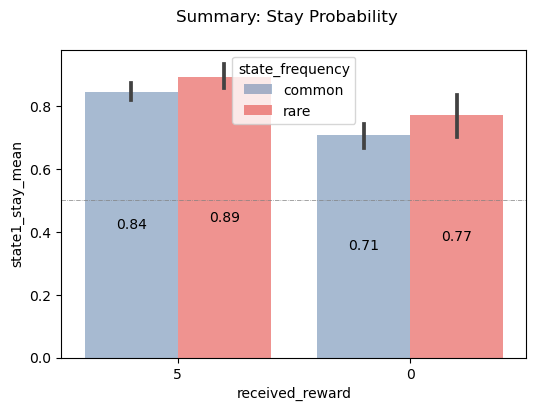

In [6]:
my_palette = sns.color_palette(["#4374B3", "#FF0B04"])

fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Summary: Stay Probability')
sns.barplot(data=df1stay_aggregate, x='received_reward', y='state1_stay_mean', 
            hue='state_frequency', 
            palette=my_palette, alpha=.5, 
            order = sorted(df1stay_aggregate['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'], 
            ax=ax)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center')
ax.axhline(0.5, color='grey', ls='-.', linewidth=.5) 
plt.show()

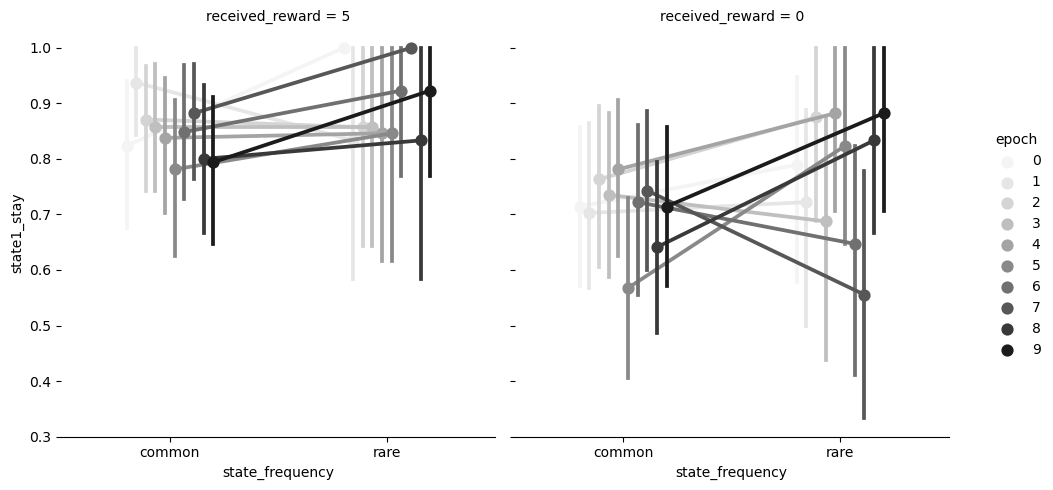

In [7]:
ax = sns.catplot(data=df1_state1stay, x='state_frequency', y='state1_stay', kind='point',
            row=None, col='received_reward', col_order = sorted(df1stay_aggregate['received_reward'].unique(), reverse=True), 
            margin_titles=True, hue='epoch', palette='Greys', dodge=.4) 
# ax.set(ylim=(0, 1.05))
ax.despine(left=True)
plt.show()

In [8]:
df1_state1stay[df1_state1stay.apply(lambda x: (x['received_reward']==0 and x['state_frequency']=='rare'), axis=1)]

,index,state_frequency,received_reward,pre_received_reward,state1_stay,state1_response_time,state2_response_time,epoch
9,9,rare,0,non-reward,1.0,0.31,0.31,0
10,10,rare,0,non-reward,0.0,0.41,0.41,0
19,19,rare,0,non-reward,0.0,0.41,0.41,0
35,35,rare,0,reward,1.0,0.41,0.41,0
36,36,rare,0,non-reward,1.0,0.41,0.31,0
...,...,...,...,...,...,...,...,...
74,74,rare,0,non-reward,1.0,0.31,0.41,9
78,78,rare,0,non-reward,1.0,0.31,0.41,9
81,81,rare,0,non-reward,1.0,0.31,0.31,9
82,82,rare,0,non-reward,0.0,0.41,0.31,9


## Simulation Results: Effect

/home/chery/.conda/envs/pyactrr/lib/python3.9/site-packages/seaborn/categorical.py:231: RuntimeWarning: All-NaN slice encountered
  native_width = np.nanmin(np.diff(unique_values))


OverflowError: Range exceeds valid bounds

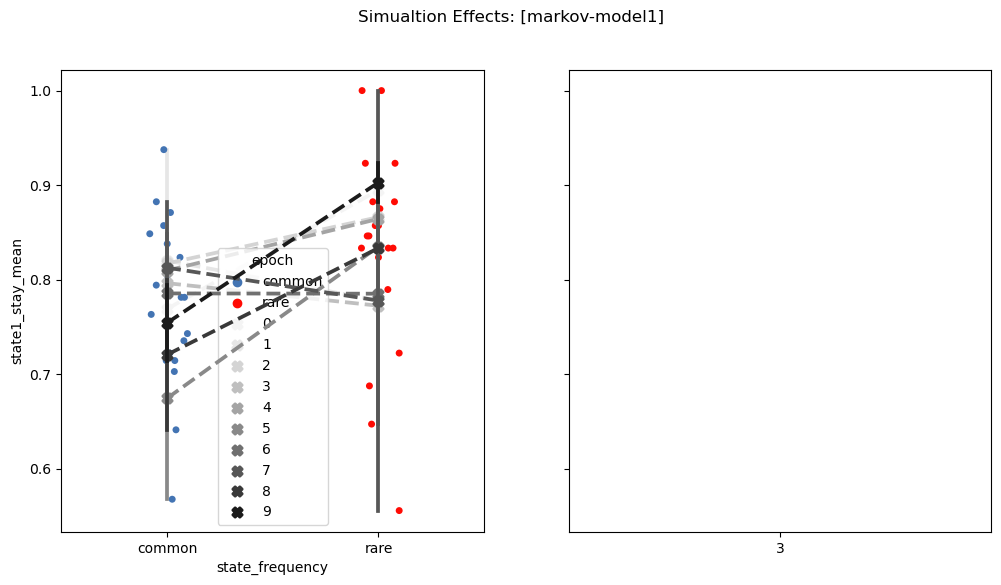

In [9]:
fig, axes = plt.subplots(1,2,figsize=(12,6), sharey=True)
fig.suptitle('Simualtion Effects: [%s]' % (model_name))
    
sns.stripplot(data=df1stay_aggregate, x='state_frequency', y='state1_stay_mean', 
            order=['common', 'rare'],  hue='state_frequency', palette=my_palette, ax=axes[0])
sns.pointplot(data=df1stay_aggregate, x='state_frequency', y='state1_stay_mean', 
              order=['common', 'rare'],  hue='epoch', palette='Greys', 
              markers='X', linestyles='--', ax=axes[0]) 

sns.stripplot(data=df1stay_aggregate, x='received_reward', y='state1_stay_mean', 
              order=[3,0],  hue='received_reward', palette='Set2', ax=axes[1])
sns.pointplot(data=df1stay_aggregate, x='received_reward', y='state1_stay_mean', 
              order=[3,0],  hue='epoch', palette='Greys', 
              markers='X', linestyles='--', ax=axes[1]) 

axes[0].set_ylim(0,1.05)
axes[0].set_title('Effect of State Frequency: \nCommon vs. Rare')
axes[1].set_title('Effect of Reward: \n3 vs. 0')
plt.show()

## Response Time

In [ ]:
df1_long = df1[['epoch', 'received_reward', 'state_frequency', 'state1_response_time', 'state2_response_time']].melt(id_vars=['epoch', 'received_reward', 'state_frequency'], value_vars=['state1_response_time', 'state2_response_time'], var_name='state_name', value_name='response_time')
df1_long['state'] = df1_long.apply(lambda x: x['state_name'].split('_')[0]+':'+x['state_frequency'], axis=1)

In [ ]:
# my_palette2 = sns.color_palette(["#0b5394", "#D9534F", "#9fc5e8", "#ECA9A7"])
# hue_order = ['state1:common', 'state1:rare', 'state2:common', 'state2:rare']

# fig, axes = plt.subplots(1,2, figsize=(15,4), sharex=True)
# fig.suptitle('Summary: Response Time')
# sns.barplot(data=df1_long, x='received_reward', y='response_time', 
#             hue='state', palette=my_palette2,
#             order = sorted(df1_long['received_reward'].unique(), reverse=True), 
#             hue_order=hue_order, ax=axes[0]) 

# sns.barplot(data=df2_long, x='received_reward', y='response_time',
#             hue='state', palette=my_palette2,  
#             order = sorted(df2_long['received_reward'].unique(), reverse=True), 
#             hue_order=hue_order, ax=axes[1]) 
# for ax in axes:
#     for container in ax.containers:
#         ax.bar_label(container, fmt='%.2f', label_type='center')    

# axes[0].legend(loc=1)
# axes[1].legend_.remove()
# axes[0].set_title('Model-Free')
# axes[1].set_title('Model-Base')

# plt.show()

In [ ]:
my_palette2 = sns.color_palette(["#0b5394", "#D9534F", "#9fc5e8", "#ECA9A7"])
hue_order = ['state1:common', 'state1:rare', 'state2:common', 'state2:rare']

fig, ax = plt.subplots()
fig.suptitle('Summary: Response Time')
sns.barplot(data=df1_long[df1_long['epoch']==0], x='received_reward', y='response_time', dodge=True,
            hue='state', palette=my_palette2,
            order = sorted(df1_long['received_reward'].unique(), reverse=True), 
            hue_order=hue_order, ax=ax)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center')    
ax.set_title('Model-Free')
 
plt.show()

# Learning Performance

In [ ]:
if load:
    df1_aggregate  = df1.groupby(['index_bin']).agg(optimal_response_sum_prop=('optimal_response_sum_prop', 'mean')).reset_index()

    ax=sns.lineplot(data=df1_aggregate, x='index_bin', y='optimal_response_sum_prop', label='Model-Free (Performance)', color='steelblue', marker='o', lw=3)
    ax.axhline(0.5, color='grey', ls='-.', linewidth=.5) 
    ax.set_ylim(0,1)
    plt.title('MODEL-FREE')
    plt.show()

In [ ]:
df1_utrace

In [ ]:
if not load:
    fig, axes = plt.subplots(2,1, figsize=(10,10))
    fig.suptitle('Summary: Performance')

    #plot
    sns.barplot(data=df1_utrace, x='action', y=':utility', hue='state', palette='Set2', ax=axes[0])
    axes[0].axhline(0, color='grey', ls='-.', linewidth=.5) 
    axes[0].set_ylim(df1_utrace[':utility'].min()*1.15, df1_utrace[':utility'].max()*1.15) 
    
    sns.lineplot(data=df1, x='index_bin', y='optimal_response_sum_prop', label='Model-Free (Optimal Response)', color='black', lw=3, ax=axes[1])
    sns.lineplot(data=df1, x='index_bin', y='received_reward_sum_prop', label='Model-Free (Gained Reward)', color='gray', lw=3,  ax=axes[1])
    axes[1].axhline(0, color='grey', ls='-.', linewidth=.5) 
    axes[0].set_ylim(df1_utrace[':utility'].min()*1.15,df1_utrace[':utility'].max()*1.15)
    
    axes[0].set_title('')
    axes[1].set_title('')
    
    plt.show()

## Reward Probabilities

In [ ]:
dfr = df1[['index', 'reward_probability_B1', 'reward_probability_B2', 'reward_probability_C1', 'reward_probability_C2']].melt(id_vars='index', var_name='state2_stimulus', value_name='reward_probability')
dfr['state2_stimulus'] = dfr.apply(lambda x:x['state2_stimulus'].split('_')[-1], axis=1)
dfr.head()

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
fig.suptitle('Reward Probabilities [Random Walk]')
ax = sns.lineplot(dfr, x='index', y='reward_probability', hue='state2_stimulus', markers='state1_stimulus')

In [ ]:
df1[['index_bin', 'state2_optimal', 'state2_optimal']].drop_duplicates()

## Activation Trace

In [ ]:
actr.hide_output()
chunk_names = ['M-A1', 'M-A2', 'M-A3', 'M-A4', 'M-B1', 'M-B2', 'M-B3', 'M-B4', 'M-C1', 'M-C2', 'M-C3', 'M-C4']
dft = pd.DataFrame(np.array([chunk_names,
             [actr.sdp(t, ':Reference-Count')[0][0] for t in chunk_names], 
             [actr.sdp(t, ':Activation')[0][0] for t in chunk_names],
             [actr.sdp(t, ':Last-Retrieval-Activation')[0][0] for t in chunk_names]]).T,
             columns=['memory', ':Reference-Count', ':Activation',':Last-Retrieval-Activation']).astype({':Reference-Count':float, ':Activation':float,':Last-Retrieval-Activation':float})

In [ ]:
dfm = df1.copy()
# state1_selected_stimulus, state2_selected_stimulus, state1_response, 
# A, B, f -> M-A1
# A, B, k -> M-A2
# A, C, f -> M-A2
# A, C, k -> M-A4

# state2_selected_stimulus, state2_response, received_reward, 
# B1, f, 3 -> M-B1
# B1, f, 0 -> M-B2
# B2, k, 3 -> M-B3
# B2, k, 0 -> M-B4 

# C1, f, 3 -> M-C1
# C1, f, 0 -> M-C2
# C2, k, 3 -> M-C3
# C2, k, 0 -> M-C4 

def map_func1(x):
    a,b,c,d,e = x['state1_selected_stimulus'], x['state2_selected_stimulus'], x['state1_response'], x['state2_response'], x['received_reward']
    if a[0] == 'A' and b[0] == 'B' and c == 'f':
        return 'M-A1'
    if a[0] == 'A' and b[0] == 'B' and c == 'k':
        return 'M-A2'
    if a[0] == 'A' and b[0] == 'C' and c == 'f':
        return 'M-A3'
    if a[0] == 'A' and b[0] == 'C' and c == 'k':
        return 'M-A4'

def map_func2(x):
    a,b,c,d,e = x['state1_selected_stimulus'], x['state2_selected_stimulus'], x['state1_response'], x['state2_response'], x['received_reward']
    if b == 'B1' and d == 'f' and e == 3:
        return 'M-B1'
    if b == 'B1' and d == 'f' and e == 0:
        return 'M-B2'
    if b == 'B2' and d == 'k' and e == 3:
        return 'M-B3'
    if b == 'B2' and d == 'k' and e == 0:
        return 'M-B4'
    
    if b == 'C1' and d == 'f' and e == 3:
        return 'M-C1'
    if b == 'C1' and d == 'f' and e == 0:
        return 'M-C2'
    if b == 'C2' and d == 'k' and e == 3:
        return 'M-C3'
    if b == 'C2' and d == 'k' and e == 0:
        return 'M-C4'
    
dfm['state1_memory'] = df1.apply(map_func1, axis=1)
dfm['state2_memory'] = df1.apply(map_func2, axis=1)

dfm_count = pd.concat([dfm.groupby(['epoch', 'state1_memory'])['index'].count().reset_index().rename(columns={'state1_memory':'memory', 'index':'trial_count'}), 
           dfm.groupby(['epoch', 'state2_memory'])['index'].count().reset_index().rename(columns={'state2_memory':'memory', 'index':'trial_count'})], axis=0)

In [ ]:
df1_atrace.head()

In [ ]:
reward_palette1 = sns.color_palette(['#f4cccc', '#882724'])
# my_chunk_palette = sns.color_palette(["#FF0B04", "#F8C4B4", "#F8C4B4", "#FF0B04", "#E6E5A3", "#557153", "#557153", "#E6E5A3", "#B1D0E0", "#1A374D", "#B1D0E0", "#1A374D"])
my_chunk_palette = sns.color_palette(["#9a8900", "#ffe500", "#ffe500", "#9a8900"]+['#882724', '#f4cccc']*4)
chunk_order = df1_atrace['memory'].sort_values().unique()

fig, axes = plt.subplots(3,1, figsize=(15,12), sharex=True)
fig.suptitle('Summary: ACT-R Memory Trace')
sns.barplot(data = df1_atrace, x='memory', y=':Reference-Count', order=chunk_order, palette=my_chunk_palette, ax=axes[0])
sns.barplot(data =df1_atrace, x='memory', y=':Activation', alpha=.7, order=chunk_order, palette=my_chunk_palette, errorbar='se', ax=axes[1])
sns.barplot(data=dfm_count, x='memory', y='trial_count', order=chunk_order, palette=my_chunk_palette, ax=axes[2])


axes[0].legend(labelcolor=['#9a8900', '#f4cccc', '#ffe500', '#9a8900'], labels=['Reward', 'Non-Reward', 'Rare', 'Common'])
axes[0].set_title('ACTR Trace: :Retrieval-Count') 
axes[1].set_title('ACTR Trace: :Activation') 
axes[2].set_title('Experiment Trial Count') 

# for ax in axes:
#     for container in ax.containers:
#         ax.bar_label(container, fmt='%.2f', label_type='center')  
plt.show()

## Sanity Check

Randomness

In [ ]:
df1[['reward_probability_B1', 'reward_probability_B2', 'reward_probability_C1', 'reward_probability_C2']].head()